          Dataset          Dimension     Score        SD  dim_key  set_key
0   Whole Dataset  avg_hallucination  4.242424  0.571534        0        0
1          German  avg_hallucination  4.313131  0.546068        0        1
2         English  avg_hallucination  4.171717  0.595826        0        2
3   Whole Dataset     avg_answer_acc  3.823232  0.804304        1        0
4          German     avg_answer_acc  3.858586  0.882036        1        1
5         English     avg_answer_acc  3.787879  0.730383        1        2
6   Whole Dataset       avg_user_sat  3.707071  0.714957        2        0
7          German       avg_user_sat  3.727273  0.728652        2        1
8         English       avg_user_sat  3.686869  0.711705        2        2
9   Whole Dataset      avg_coherence  4.333333  0.535891        3        0
10         German      avg_coherence  4.343434  0.574244        3        1
11        English      avg_coherence  4.323232  0.503356        3        2
12  Whole Dataset   avg_c

C:\Users\wurch\AppData\Local\Temp\ipykernel_50424\2651043607.py:68: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(
C:\Users\wurch\AppData\Local\Temp\ipykernel_50424\2651043607.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels)


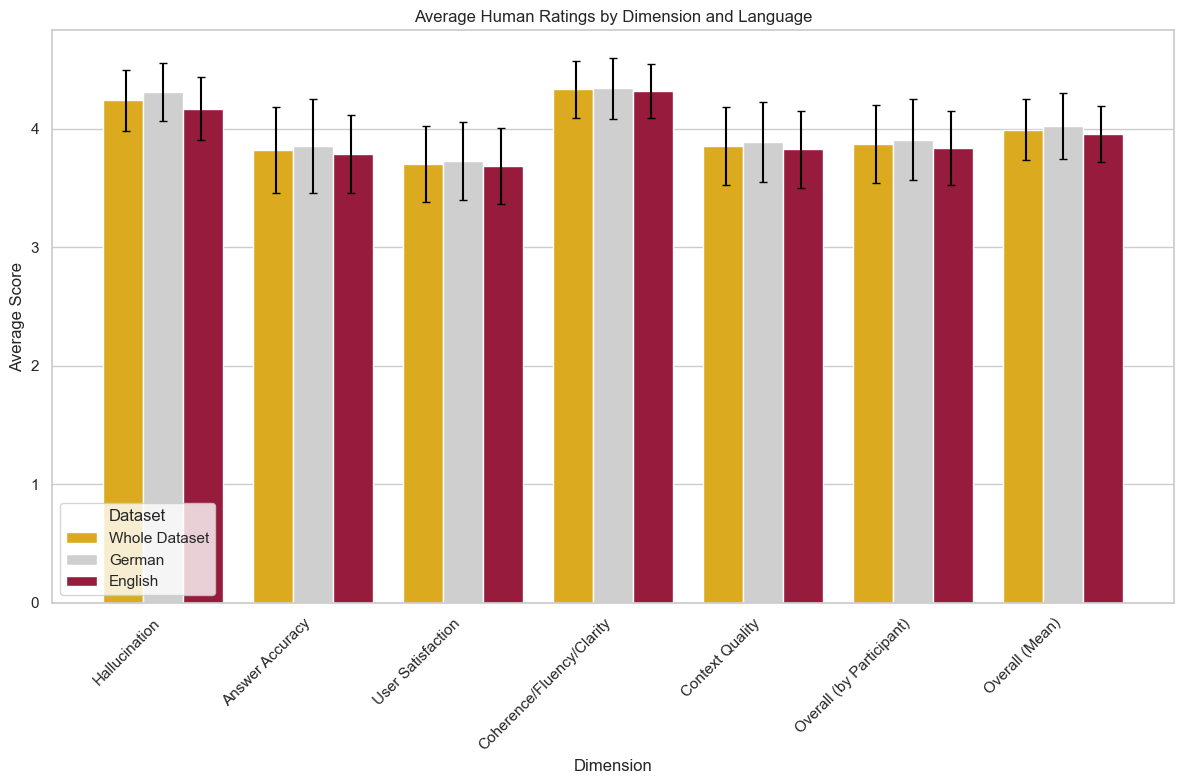

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Load the averaged human evaluations
df = pd.read_csv("../../../data/human_eval_avg.csv", encoding="utf-8")

# 2) Identify the columns corresponding to the averaged dimensions
dimensions = [
    "avg_hallucination",
    "avg_answer_acc",
    "avg_user_sat",
    "avg_coherence",
    "avg_context_qual",
    "avg_overall",
    "overall_mean"
]

# 3) Compute means and standard deviations
all_means = df[dimensions].mean().rename("Whole Dataset")
de_means  = df[df["langq"] == "de"][dimensions].mean().rename("German")
en_means  = df[df["langq"] == "en"][dimensions].mean().rename("English")

all_stds = df[dimensions].std().rename("Whole Dataset")
de_stds  = df[df["langq"] == "de"][dimensions].std().rename("German")
en_stds  = df[df["langq"] == "en"][dimensions].std().rename("English")

# Combine means into one DataFrame
mean_df = pd.concat([all_means, de_means, en_means], axis=1).transpose().reset_index()
mean_df = mean_df.rename(columns={"index": "Dataset"})

# Combine stds into one DataFrame
std_df = pd.concat([all_stds, de_stds, en_stds], axis=1).transpose().reset_index()
std_df = std_df.rename(columns={"index": "Dataset"})

# Reshape (melt) for plotting
melted_means = mean_df.melt(id_vars="Dataset", var_name="Dimension", value_name="Score")
melted_stds  = std_df.melt(id_vars="Dataset", var_name="Dimension", value_name="SD")

# Merge means & SD into one DataFrame
melted_df = pd.merge(melted_means, melted_stds, on=["Dataset", "Dimension"])

# --- Sort to ensure the data is in [Dimension1: Whole, German, English, Dimension2: Whole, ...] order
#     so the naive indexing approach will match the bar positions.
#     If you want a custom dimension order, specify a list or dictionary:
dimension_order = {
    "avg_hallucination": 0,
    "avg_answer_acc": 1,
    "avg_user_sat": 2,
    "avg_coherence": 3,
    "avg_context_qual": 4,
    "avg_overall": 5,
    "overall_mean": 6
}
dataset_order = {"Whole Dataset": 0, "German": 1, "English": 2}

# Create numeric sort keys
melted_df["dim_key"] = melted_df["Dimension"].map(dimension_order)
melted_df["set_key"] = melted_df["Dataset"].map(dataset_order)
melted_df = melted_df.sort_values(["dim_key", "set_key"]).reset_index(drop=True)

print(melted_df)
palette = {'Whole Dataset': '#fbb900', 'German': '#cfcfcf', 'English': '#ac0634'}

# 4) Plot using seaborn (without yerr)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=melted_df,
    x="Dimension",
    y="Score",
    hue="Dataset",
    ci=None,           # Turn off Seaborn's built-in confidence intervals
    palette=palette,
    dodge=True
)

# Manually add error bars
#
# We have 7 dimensions, each with 3 subsets => 21 rows total.
# i // 3 gives the dimension index (0..6).
# i % 3  gives the dataset index (0..2).
#
# The expression (i // 3) + ((i % 3) * 0.25) - 0.25 is a quick hack
# to shift each dataset's bar slightly so they don't overlap.
# Adjust the 0.25 spacing if you change "dodge" or have more subsets.
#
for i in range(len(melted_df)):
    x_pos = (i // 3) + (i % 3) * 0.25 - 0.25
    y_pos = melted_df.loc[i, "Score"]
    y_err = melted_df.loc[i, "SD"] * 0.45
    plt.errorbar(
        x=x_pos,
        y=y_pos,
        yerr=y_err,
        fmt='none',    # no marker
        c='black',
        capsize=3
    )

# Style the axes
plt.title("Average Human Ratings by Dimension and Language")
plt.xlabel("Dimension")
plt.ylabel("Average Score")
plt.xticks(rotation=45, ha="right")

# Adjust the x-tick labels if desired:
xtick_labels = {
    'avg_hallucination': 'Hallucination',
    'avg_answer_acc': 'Answer Accuracy',
    'avg_user_sat': 'User Satisfaction',
    'avg_coherence': 'Coherence/Fluency/Clarity',
    'avg_context_qual': 'Context Quality',
    'avg_overall': 'Overall (by Participant)',
    'overall_mean': 'Overall (Mean)'
}
current_ticks = plt.gca().get_xticks()
current_labels = plt.gca().get_xticklabels()
new_labels = []
for label in current_labels:
    raw_text = label.get_text()
    new_labels.append(xtick_labels.get(raw_text, raw_text))
plt.gca().set_xticklabels(new_labels)

plt.legend(title="Dataset")
plt.tight_layout()
# save the plot
plt.savefig("../../../data/figures/eval_survey/human_eval_avg.png")
plt.show()



          Dataset          Dimension     Score
0   Whole Dataset  avg_hallucination  4.242424
1          German  avg_hallucination  4.313131
2         English  avg_hallucination  4.171717
3   Whole Dataset     avg_answer_acc  3.823232
4          German     avg_answer_acc  3.858586
5         English     avg_answer_acc  3.787879
6   Whole Dataset       avg_user_sat  3.707071
7          German       avg_user_sat  3.727273
8         English       avg_user_sat  3.686869
9   Whole Dataset      avg_coherence  4.333333
10         German      avg_coherence  4.343434
11        English      avg_coherence  4.323232
12  Whole Dataset   avg_context_qual  3.858586
13         German   avg_context_qual  3.888889
14        English   avg_context_qual  3.828283
15  Whole Dataset        avg_overall  3.873737
16         German        avg_overall  3.909091
17        English        avg_overall  3.838384
18  Whole Dataset       overall_mean  3.992929
19         German       overall_mean  4.026263
20        Eng

C:\Users\wurch\AppData\Local\Temp\ipykernel_51620\3312017098.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels([xtick_labels[label.get_text()] for label in barplot.get_xticklabels()])


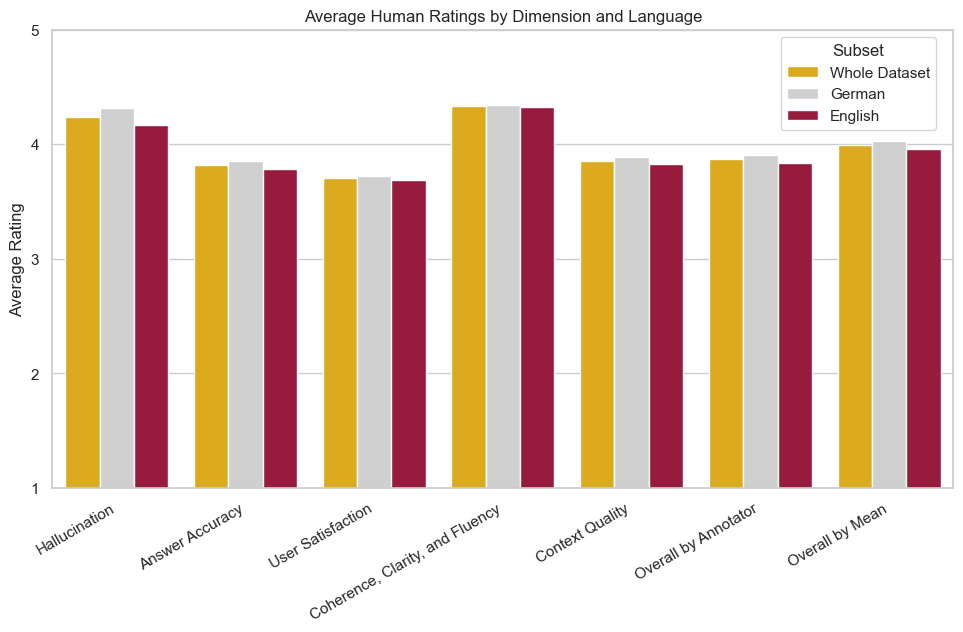

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Load the averaged human evaluations
df = pd.read_csv("../../../data/human_eval_avg.csv", encoding="utf-8")

# 2) Identify the columns corresponding to the averaged dimensions
dimensions = [
    "avg_hallucination",
    "avg_answer_acc",
    "avg_user_sat",
    "avg_coherence",
    "avg_context_qual",
    "avg_overall",
    "overall_mean"
]

# 3) Compute dimension-by-dimension averages for:
#    a) The entire dataset (Whole Dataset)
#    b) The German subset (langq == 'de')
#    c) The English subset (langq == 'en')

all_means = df[dimensions].mean().rename("Whole Dataset")
de_means  = df[df["langq"] == "de"][dimensions].mean().rename("German")
en_means  = df[df["langq"] == "en"][dimensions].mean().rename("English")

# Combine the three Series into one DataFrame for easy plotting
mean_df = pd.concat([all_means, de_means, en_means], axis=1).transpose().reset_index()
mean_df = mean_df.rename(columns={"index": "Dataset"})

# Reshape for seaborn (tidy format)
melted_df = mean_df.melt(id_vars="Dataset", var_name="Dimension", value_name="Score")
print(melted_df)

# Define the new x-tick labels
xtick_labels = {
    'avg_hallucination': 'Hallucination',
    'avg_answer_acc': 'Answer Accuracy',
    'avg_user_sat': 'User Satisfaction',
    'avg_coherence': 'Coherence, Clarity, and Fluency',
    'avg_context_qual': 'Context Quality',
    'avg_overall': 'Overall by Annotator',
    'overall_mean': 'Overall by Mean'
}
# Define the color palette
palette = {'Whole Dataset': '#fbb900', 'German': '#cfcfcf', 'English': '#ac0634'}

# 4) Plot using seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))  # Resize the plot

barplot = sns.barplot(
    data=melted_df,
    x="Dimension",
    y="Score",
    hue="Dataset",
    palette=palette,
    dodge=True
)

# Optional aesthetics
plt.ylim(1, 5)  # Because your ratings range from 1 to 5
plt.title("Average Human Ratings by Dimension and Language")
plt.xlabel("")
plt.ylabel("Average Rating")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Subset", bbox_to_anchor=(0.8, 1), loc="upper left")  # Adjust legend position
plt.tight_layout()

# Set the new x-tick labels
barplot.set_xticklabels([xtick_labels[label.get_text()] for label in barplot.get_xticklabels()])
# Set y-axis to show only full integers
plt.yticks(range(1, 6))
plt.show()

Rating                1          2          3          4          5
Dimension                                                          
hallucination  1.010101   5.555556  16.161616  22.727273  54.545455
answer_acc     4.040404  12.626263  19.191919  25.252525  38.888889
user_sat       3.030303  14.141414  21.212121  32.323232  29.292929
coherence      1.010101   3.535354   7.070707  37.878788  50.505051
context_qual   4.545455  10.606061  16.666667  30.808081  37.373737
overall        2.020202  12.626263  17.171717  32.323232  35.858586


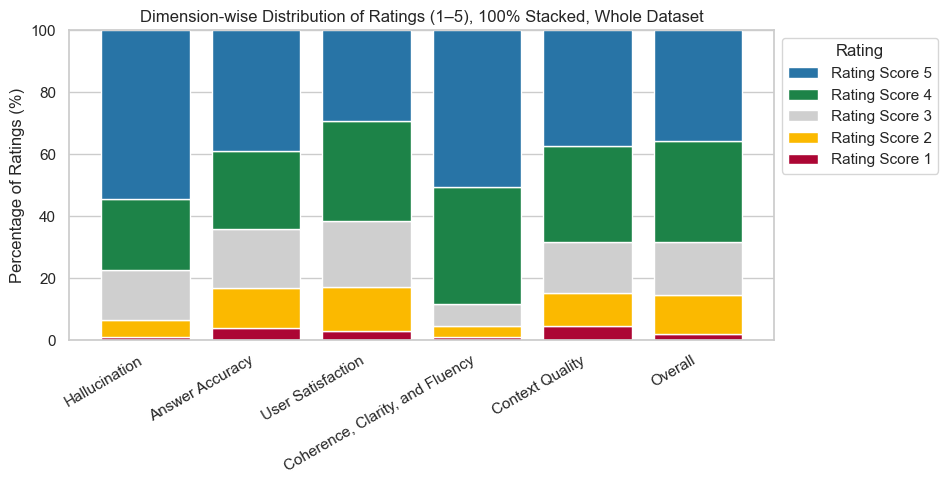

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------
# 1) Load your long-format data (each row = 1 rating from 1 annotator)
#    If you only have a wide dataset with means, you won't be able
#    to get distributions for each rating. This example assumes
#    you have columns like ['hallucination', 'answer_acc', 'user_sat', ...]
#    each with values in {1,2,3,4,5} or "A1"..."A5".
# -------------------------------------------------------------------
df_long = pd.read_csv("../../../data//human_eval/human_eval_long.csv", encoding="utf-8")

# If the columns are still A1..A5, map them to numeric:
rating_map = {'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5}
for dim in ["hallucination", "answer_acc", "user_sat", "coherence", "context_qual", "overall"]:
    df_long[dim] = df_long[dim].map(rating_map)

# Define the new x-tick labels
xtick_labels = {
    'hallucination': 'Hallucination',
    'answer_acc': 'Answer Accuracy',
    'user_sat': 'User Satisfaction',
    'coherence': 'Coherence, Clarity, and Fluency',
    'context_qual': 'Context Quality',
    'overall': 'Overall by Annotator',
}

# -------------------------------------------------------------------
# 2) We want the distribution of ratings 1..5 for each dimension.
#    We'll melt the data so there's one row per (dimension, rating).
# -------------------------------------------------------------------
melted = df_long.melt(
    id_vars=['id','question_number','langq'], 
    value_vars=["hallucination","answer_acc","user_sat","coherence","context_qual","overall"],
    var_name="Dimension", 
    value_name="Rating"
)
# Now each row says which dimension was rated, and what rating (1..5)

# -------------------------------------------------------------------
# 3) Count how many times each dimension has each rating
# -------------------------------------------------------------------

counts = melted.groupby(["Dimension","Rating"]).size().reset_index(name="Count")

# -------------------------------------------------------------------
# 4) Pivot so each row is a dimension, each column is a rating, and
#    the cells are the frequency counts
# -------------------------------------------------------------------
counts_pivot = counts.pivot(index="Dimension", columns="Rating", values="Count").fillna(0)

# -------------------------------------------------------------------
# 5) Convert to row-wise percentages for 100% stacking
# -------------------------------------------------------------------
row_sums = counts_pivot.sum(axis=1)
counts_pivot_perc = counts_pivot.div(row_sums, axis=0) * 100

new_order = ['hallucination', 'answer_acc', 'user_sat', 'coherence', 'context_qual', 'overall']  # Adjust as needed
new_ticks = ['Hallucination', 'Answer Accuracy', 'User Satisfaction', 'Coherence, Clarity, and Fluency', 'Context Quality', 'Overall']  # Adjust as needed
counts_pivot_perc = counts_pivot_perc.reindex(new_order)

print(counts_pivot_perc)

# counts_pivot_perc now has the percentage distribution of ratings 1..5
# for each dimension, summing to 100% per row.
# Example structure:
# Rating           1      2      3      4      5
# Dimension
# hallucination   10.0   20.0   30.0   25.0   15.0
# answer_acc       5.0   15.0   40.0   30.0   10.0
# ...

# -------------------------------------------------------------------
# 6) Plot as a 100%-stacked bar chart in Matplotlib.
#    (Seaborn does not have a direct "stacked bar" function.)
# -------------------------------------------------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# We'll plot row by row. The "bottom" for each bar is the sum of
# all previously plotted segments.
bottom = [0]*len(counts_pivot_perc.index)
ratings = sorted(counts_pivot_perc.columns)  # should be [1,2,3,4,5]

palette = ['#ac0634','#fbb900', '#cfcfcf', '#1d8348', '#2874a6']
for rating in ratings:
    plt.bar(
        x=counts_pivot_perc.index,
        height=counts_pivot_perc[rating],
        bottom=bottom,
        label=f"Rating Score {rating}",
        color=palette[rating-1],
    )
    # update 'bottom' so the next rating stacks above
    bottom = [i+j for i,j in zip(bottom, counts_pivot_perc[rating])]

# Some cosmetics
plt.legend(title="Rating")
plt.ylabel("Percentage of Ratings (%)")
plt.title("Dimension-wise Distribution of Ratings (1–5), 100% Stacked, Whole Dataset")
plt.xticks(ticks=range(len(new_order)), labels=new_ticks, rotation=30, ha="right")
plt.ylim(0, 100)
plt.tight_layout()

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="Rating", bbox_to_anchor=(1, 1), loc="upper left")  # Adjust legend position
plt.savefig(
    "../../../data/figures/eval_survey/human_eval_stacked_bar.png",
    bbox_inches="tight"  # Ensures all elements, including the legend, are included
)
plt.show()


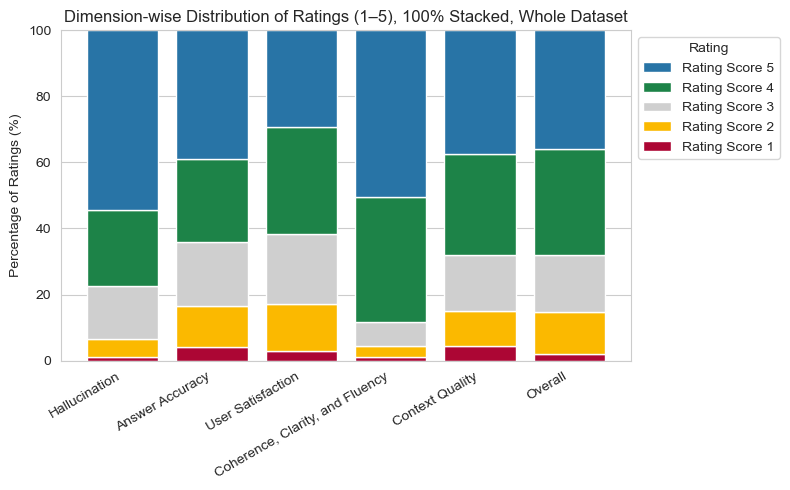

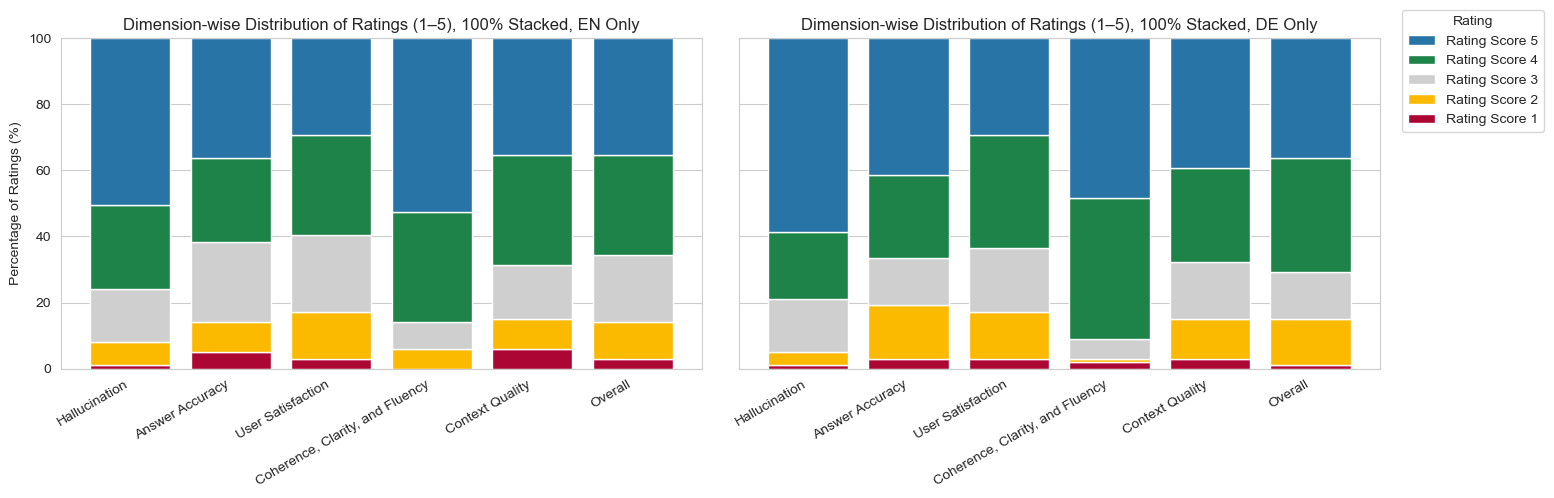

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------
# 1) Load your long-format data
# -------------------------------------------------------------------
df_long = pd.read_csv("../../../data//human_eval/human_eval_long.csv", encoding="utf-8")

# If the columns are still A1..A5, map them to numeric:
rating_map = {'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5}
for dim in ["hallucination", "answer_acc", "user_sat", "coherence", "context_qual", "overall"]:
    df_long[dim] = df_long[dim].map(rating_map)

# Define the new x-tick labels
xtick_labels = {
    'hallucination': 'Hallucination',
    'answer_acc': 'Answer Accuracy',
    'user_sat': 'User Satisfaction',
    'coherence': 'Coherence, Clarity, and Fluency',
    'context_qual': 'Context Quality',
    'overall': 'Overall by Annotator',
}

# -------------------------------------------------------------------
# 2) Melt the data: one row per (dimension, rating)
# -------------------------------------------------------------------
melted = df_long.melt(
    id_vars=['id','question_number','langq'], 
    value_vars=["hallucination","answer_acc","user_sat","coherence","context_qual","overall"],
    var_name="Dimension", 
    value_name="Rating"
)

# -------------------------------------------------------------------
# 3) Count how many times each dimension has each rating (whole dataset)
# -------------------------------------------------------------------
counts = melted.groupby(["Dimension","Rating"]).size().reset_index(name="Count")

# -------------------------------------------------------------------
# 4) Pivot so each row is a dimension, each column is a rating
# -------------------------------------------------------------------
counts_pivot = counts.pivot(index="Dimension", columns="Rating", values="Count").fillna(0)

# -------------------------------------------------------------------
# 5) Convert to row-wise percentages (100% stacked)
# -------------------------------------------------------------------
row_sums = counts_pivot.sum(axis=1)
counts_pivot_perc = counts_pivot.div(row_sums, axis=0) * 100

# Reorder rows if desired, and define tick labels
new_order = ['hallucination', 'answer_acc', 'user_sat', 'coherence', 'context_qual', 'overall']
new_ticks = [
    'Hallucination', 
    'Answer Accuracy', 
    'User Satisfaction', 
    'Coherence, Clarity, and Fluency', 
    'Context Quality', 
    'Overall'
]
counts_pivot_perc = counts_pivot_perc.reindex(new_order)

# -------------------------------------------------------------------
# 6) Plot the 100%-stacked bar chart (whole dataset)
# -------------------------------------------------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

bottom = [0]*len(counts_pivot_perc.index)
ratings = sorted(counts_pivot_perc.columns)  # [1, 2, 3, 4, 5]

palette = ['#ac0634','#fbb900', '#cfcfcf', '#1d8348', '#2874a6']  # One color per rating
for rating in ratings:
    plt.bar(
        x=counts_pivot_perc.index,
        height=counts_pivot_perc[rating],
        bottom=bottom,
        label=f"Rating Score {rating}",
        color=palette[rating-1],
    )
    bottom = [i + j for i, j in zip(bottom, counts_pivot_perc[rating])]

plt.ylabel("Percentage of Ratings (%)")
plt.title("Dimension-wise Distribution of Ratings (1–5), 100% Stacked, Whole Dataset")
plt.xticks(ticks=range(len(new_order)), labels=new_ticks, rotation=30, ha="right")
plt.ylim(0, 100)

# Reverse legend order so rating 5 is at top
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="Rating", bbox_to_anchor=(1, 1), loc="upper left")

plt.tight_layout()
plt.savefig("../../../data/figures/eval_survey/human_eval_stacked_bar.png", bbox_inches="tight")
plt.show()

# -------------------------------------------------------------------
# 7) CREATE A SPLIT VERSION BY LANGUAGE
#    We'll create a second figure with two subplots: one for EN, one for DE.
# -------------------------------------------------------------------
fig, axes = plt.subplots(ncols=2, figsize=(14, 5), sharey=True)

palette = ['#ac0634','#fbb900', '#cfcfcf', '#1d8348', '#2874a6']  # same palette
ratings = [1,2,3,4,5]

for ax, lang_label in zip(axes, ['en', 'de']):
    # Filter the melted data for the specific language
    subdf = melted[melted['langq'] == lang_label]
    
    # Group and pivot as before, but only for that language
    counts_lang = subdf.groupby(["Dimension","Rating"]).size().reset_index(name="Count")
    pivot_lang = counts_lang.pivot(index="Dimension", columns="Rating", values="Count").fillna(0)
    
    # Convert to percentages
    row_sums_lang = pivot_lang.sum(axis=1)
    pivot_lang_perc = pivot_lang.div(row_sums_lang, axis=0) * 100
    
    # Reindex in the same dimension order
    pivot_lang_perc = pivot_lang_perc.reindex(new_order)
    
    # Plot as 100%-stacked bars on this subplot
    bottom = [0]*len(pivot_lang_perc.index)
    for rating in ratings:
        ax.bar(
            x=pivot_lang_perc.index,
            height=pivot_lang_perc[rating],
            bottom=bottom,
            label=f"Rating Score {rating}",
            color=palette[rating-1],
        )
        bottom = [i + j for i, j in zip(bottom, pivot_lang_perc[rating])]
    
    ax.set_title(f"Dimension-wise Distribution of Ratings (1–5), 100% Stacked, {lang_label.upper()} Only")
    ax.set_xticks(range(len(new_order)))
    ax.set_xticklabels(new_ticks, rotation=30, ha="right")
    ax.set_ylim(0, 100)
    if lang_label == 'en':
        ax.set_ylabel("Percentage of Ratings (%)")

# Make a single legend for both subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], title="Rating",
           bbox_to_anchor=(1, 1), loc="upper left")

plt.tight_layout()
plt.savefig("../../../data/figures/eval_survey/human_eval_stacked_bar_lang_split.png", bbox_inches="tight")
plt.show()


Rating                1          2          3          4          5
Dimension                                                          
hallucination  1.010101   4.040404  16.161616  20.202020  58.585859
answer_acc     3.030303  16.161616  14.141414  25.252525  41.414141
user_sat       3.030303  14.141414  19.191919  34.343434  29.292929
coherence      2.020202   1.010101   6.060606  42.424242  48.484848
context_qual   3.030303  12.121212  17.171717  28.282828  39.393939
overall        1.010101  14.141414  14.141414  34.343434  36.363636


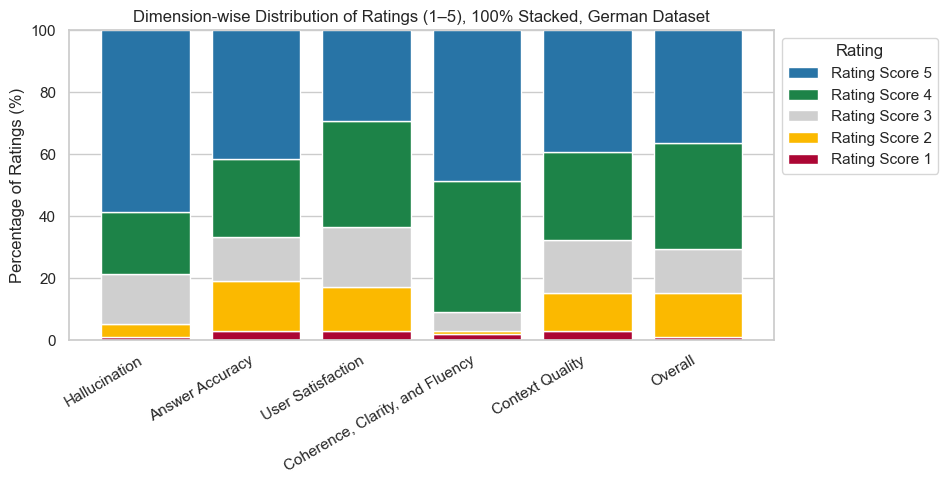

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------
# 1) Load your long-format data (each row = 1 rating from 1 annotator)
#    If you only have a wide dataset with means, you won't be able
#    to get distributions for each rating. This example assumes
#    you have columns like ['hallucination', 'answer_acc', 'user_sat', ...]
#    each with values in {1,2,3,4,5} or "A1"..."A5".
# -------------------------------------------------------------------
df_long = pd.read_csv("../../../data//human_eval/human_eval_long.csv", encoding="utf-8")

# only german
df_long = df_long[df_long["langq"] == "de"]

# If the columns are still A1..A5, map them to numeric:
rating_map = {'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5}
for dim in ["hallucination", "answer_acc", "user_sat", "coherence", "context_qual", "overall"]:
    df_long[dim] = df_long[dim].map(rating_map)

# Define the new x-tick labels
xtick_labels = {
    'hallucination': 'Hallucination',
    'answer_acc': 'Answer Accuracy',
    'user_sat': 'User Satisfaction',
    'coherence': 'Coherence, Clarity, and Fluency',
    'context_qual': 'Context Quality',
    'overall': 'Overall by Annotator',
}

# -------------------------------------------------------------------
# 2) We want the distribution of ratings 1..5 for each dimension.
#    We'll melt the data so there's one row per (dimension, rating).
# -------------------------------------------------------------------
melted = df_long.melt(
    id_vars=['id','question_number','langq'], 
    value_vars=["hallucination","answer_acc","user_sat","coherence","context_qual","overall"],
    var_name="Dimension", 
    value_name="Rating"
)
# Now each row says which dimension was rated, and what rating (1..5)

# -------------------------------------------------------------------
# 3) Count how many times each dimension has each rating
# -------------------------------------------------------------------

counts = melted.groupby(["Dimension","Rating"]).size().reset_index(name="Count")

# -------------------------------------------------------------------
# 4) Pivot so each row is a dimension, each column is a rating, and
#    the cells are the frequency counts
# -------------------------------------------------------------------
counts_pivot = counts.pivot(index="Dimension", columns="Rating", values="Count").fillna(0)


# -------------------------------------------------------------------
# 5) Convert to row-wise percentages for 100% stacking
# -------------------------------------------------------------------
row_sums = counts_pivot.sum(axis=1)
counts_pivot_perc = counts_pivot.div(row_sums, axis=0) * 100

new_order = ['hallucination', 'answer_acc', 'user_sat', 'coherence', 'context_qual', 'overall']  # Adjust as needed
new_ticks = ['Hallucination', 'Answer Accuracy', 'User Satisfaction', 'Coherence, Clarity, and Fluency', 'Context Quality', 'Overall']  # Adjust as needed
counts_pivot_perc = counts_pivot_perc.reindex(new_order)

print(counts_pivot_perc)
# counts_pivot_perc now has the percentage distribution of ratings 1..5
# for each dimension, summing to 100% per row.
# Example structure:
# Rating           1      2      3      4      5
# Dimension
# hallucination   10.0   20.0   30.0   25.0   15.0
# answer_acc       5.0   15.0   40.0   30.0   10.0
# ...

# -------------------------------------------------------------------
# 6) Plot as a 100%-stacked bar chart in Matplotlib.
#    (Seaborn does not have a direct "stacked bar" function.)
# -------------------------------------------------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# We'll plot row by row. The "bottom" for each bar is the sum of
# all previously plotted segments.
bottom = [0]*len(counts_pivot_perc.index)
ratings = sorted(counts_pivot_perc.columns)  # should be [1,2,3,4,5]

palette = ['#ac0634','#fbb900', '#cfcfcf', '#1d8348', '#2874a6']
for rating in ratings:
    plt.bar(
        x=counts_pivot_perc.index,
        height=counts_pivot_perc[rating],
        bottom=bottom,
        label=f"Rating Score {rating}",
        color=palette[rating-1],
    )
    # update 'bottom' so the next rating stacks above
    bottom = [i+j for i,j in zip(bottom, counts_pivot_perc[rating])]

# Some cosmetics
plt.legend(title="Rating")
plt.ylabel("Percentage of Ratings (%)")
plt.title("Dimension-wise Distribution of Ratings (1–5), 100% Stacked, German Dataset")
plt.xticks(ticks=range(len(new_order)), labels=new_ticks, rotation=30, ha="right")
plt.ylim(0, 100)
plt.tight_layout()

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="Rating", bbox_to_anchor=(1, 1), loc="upper left")  # Adjust legend position
plt.show()


Rating                1          2          3          4          5
Dimension                                                          
hallucination  1.010101   7.070707  16.161616  25.252525  50.505051
answer_acc     5.050505   9.090909  24.242424  25.252525  36.363636
user_sat       3.030303  14.141414  23.232323  30.303030  29.292929
coherence      0.000000   6.060606   8.080808  33.333333  52.525253
context_qual   6.060606   9.090909  16.161616  33.333333  35.353535
overall        3.030303  11.111111  20.202020  30.303030  35.353535


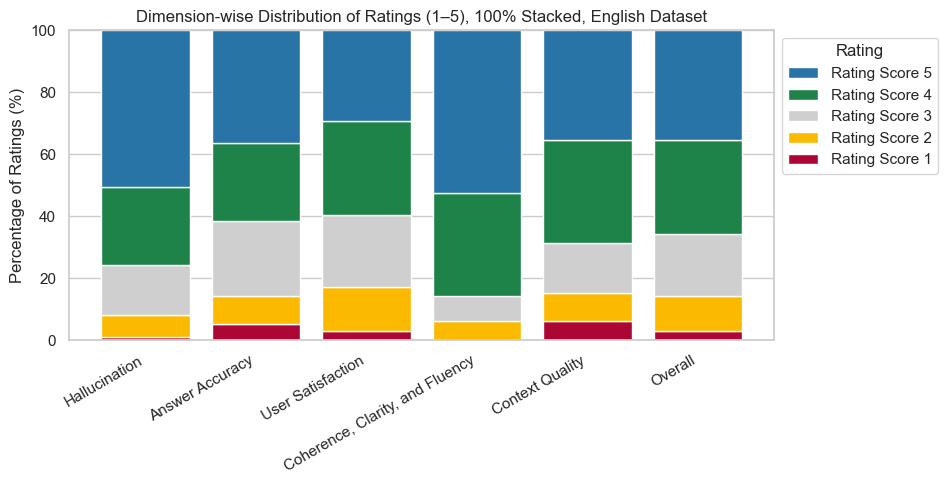

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------
# 1) Load your long-format data (each row = 1 rating from 1 annotator)
#    If you only have a wide dataset with means, you won't be able
#    to get distributions for each rating. This example assumes
#    you have columns like ['hallucination', 'answer_acc', 'user_sat', ...]
#    each with values in {1,2,3,4,5} or "A1"..."A5".
# -------------------------------------------------------------------
df_long = pd.read_csv("../../../data//human_eval/human_eval_long.csv", encoding="utf-8")

# only english
df_long = df_long[df_long["langq"] == "en"]

# If the columns are still A1..A5, map them to numeric:
rating_map = {'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5}
for dim in ["hallucination", "answer_acc", "user_sat", "coherence", "context_qual", "overall"]:
    df_long[dim] = df_long[dim].map(rating_map)

# Define the new x-tick labels
xtick_labels = {
    'hallucination': 'Hallucination',
    'answer_acc': 'Answer Accuracy',
    'user_sat': 'User Satisfaction',
    'coherence': 'Coherence, Clarity, and Fluency',
    'context_qual': 'Context Quality',
    'overall': 'Overall by Annotator',
}

# -------------------------------------------------------------------
# 2) We want the distribution of ratings 1..5 for each dimension.
#    We'll melt the data so there's one row per (dimension, rating).
# -------------------------------------------------------------------
melted = df_long.melt(
    id_vars=['id','question_number','langq'], 
    value_vars=["hallucination","answer_acc","user_sat","coherence","context_qual","overall"],
    var_name="Dimension", 
    value_name="Rating"
)
# Now each row says which dimension was rated, and what rating (1..5)

# -------------------------------------------------------------------
# 3) Count how many times each dimension has each rating
# -------------------------------------------------------------------

counts = melted.groupby(["Dimension","Rating"]).size().reset_index(name="Count")

# -------------------------------------------------------------------
# 4) Pivot so each row is a dimension, each column is a rating, and
#    the cells are the frequency counts
# -------------------------------------------------------------------
counts_pivot = counts.pivot(index="Dimension", columns="Rating", values="Count").fillna(0)

# -------------------------------------------------------------------
# 5) Convert to row-wise percentages for 100% stacking
# -------------------------------------------------------------------
row_sums = counts_pivot.sum(axis=1)
counts_pivot_perc = counts_pivot.div(row_sums, axis=0) * 100

new_order = ['hallucination', 'answer_acc', 'user_sat', 'coherence', 'context_qual', 'overall']  # Adjust as needed
new_ticks = ['Hallucination', 'Answer Accuracy', 'User Satisfaction', 'Coherence, Clarity, and Fluency', 'Context Quality', 'Overall']  # Adjust as needed
counts_pivot_perc = counts_pivot_perc.reindex(new_order)
print(counts_pivot_perc)

# counts_pivot_perc now has the percentage distribution of ratings 1..5
# for each dimension, summing to 100% per row.
# Example structure:
# Rating           1      2      3      4      5
# Dimension
# hallucination   10.0   20.0   30.0   25.0   15.0
# answer_acc       5.0   15.0   40.0   30.0   10.0
# ...

# -------------------------------------------------------------------
# 6) Plot as a 100%-stacked bar chart in Matplotlib.
#    (Seaborn does not have a direct "stacked bar" function.)
# -------------------------------------------------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# We'll plot row by row. The "bottom" for each bar is the sum of
# all previously plotted segments.
bottom = [0]*len(counts_pivot_perc.index)
ratings = sorted(counts_pivot_perc.columns)  # should be [1,2,3,4,5]

palette = ['#ac0634','#fbb900', '#cfcfcf', '#1d8348', '#2874a6']
for rating in ratings:
    plt.bar(
        x=counts_pivot_perc.index,
        height=counts_pivot_perc[rating],
        bottom=bottom,
        label=f"Rating Score {rating}",
        color=palette[rating-1],
    )
    # update 'bottom' so the next rating stacks above
    bottom = [i+j for i,j in zip(bottom, counts_pivot_perc[rating])]

# Some cosmetics
plt.legend(title="Rating")
plt.ylabel("Percentage of Ratings (%)")
plt.title("Dimension-wise Distribution of Ratings (1–5), 100% Stacked, English Dataset")
plt.xticks(ticks=range(len(new_order)), labels=new_ticks, rotation=30, ha="right")
plt.ylim(0, 100)
plt.tight_layout()

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="Rating", bbox_to_anchor=(1, 1), loc="upper left")  # Adjust legend position
plt.show()
